In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,roc_curve,auc 
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import time

In [8]:
df = pd.read_csv("./bankDataset/bank-full.csv",sep = ";")

In [9]:
#Encode data using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    df[column] = LabelEncoder().fit_transform(df[column])


In [10]:
X = df.drop("y",axis = 1)
y = df["y"]

## SEMI-SUPERVISED ENSEMBLE

/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


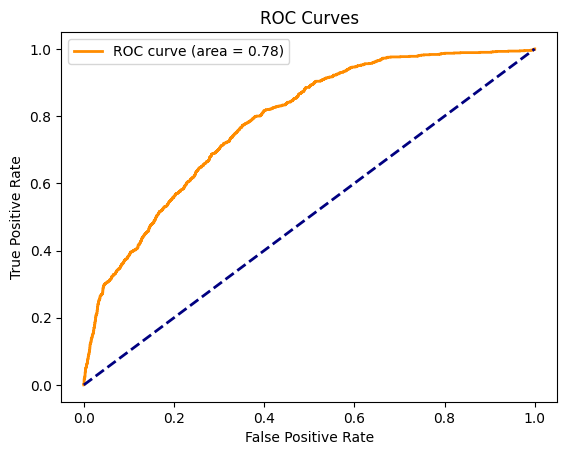

/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


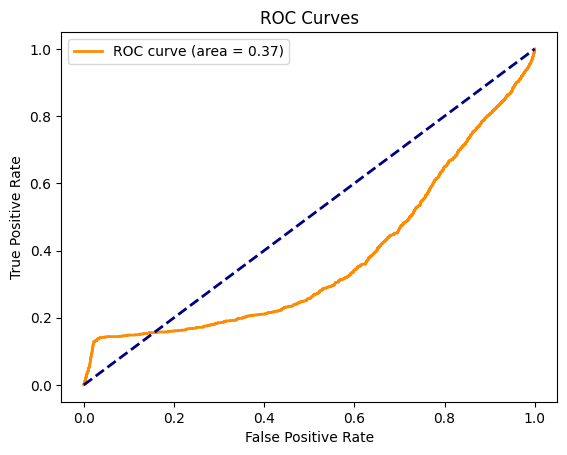

/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


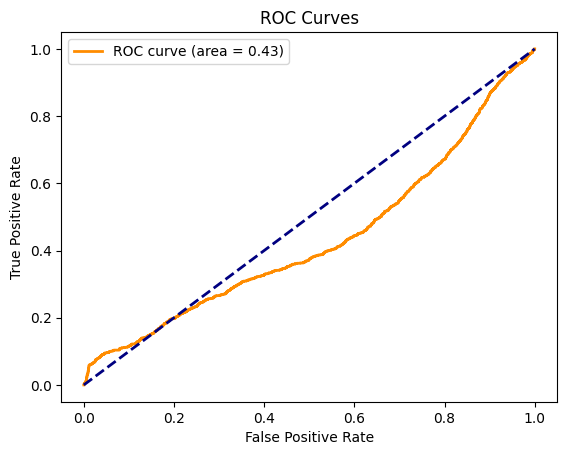

/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


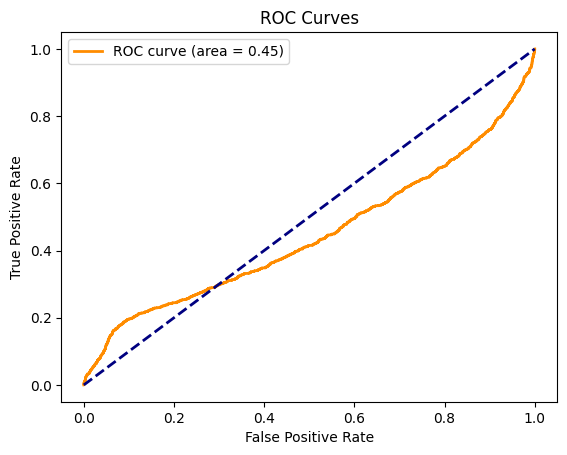

/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


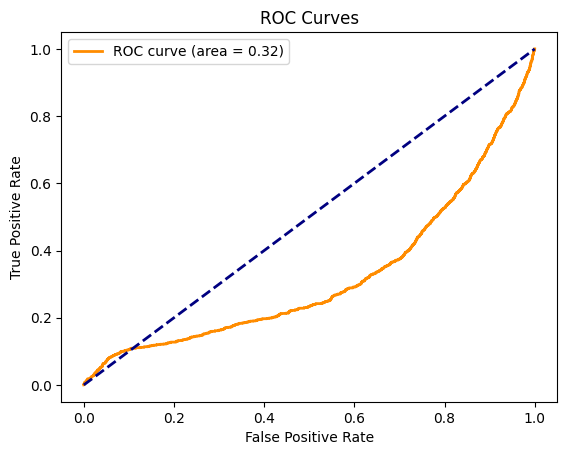

[0.8759261307088355, 0.8752626340816101, 0.8762578790224483, 0.8780272033617162, 0.8786906999889417]
[0.3461538461538461, 0.19999999999999998, 0.10120481927710845, 0.04336513443191674, 0.014375561545372867]
[0.7820154197411784, 0.3740121757123862, 0.4333303902240206, 0.44715866233145896, 0.3217288377377002]


In [11]:
unlabelled_proportions = [0.5, 0.75, 0.9, 0.95, 0.99]
accuracies = []
f1_scores = []
runtimes = []
roc_auc_scores = []


tree_clf = DecisionTreeClassifier(random_state = 42)
svm_clf = SVC(probability=True, random_state=42)
ensemble_clf = VotingClassifier(estimators=[('dt', tree_clf), ('svm', svm_clf)], voting='soft')

for proportion in unlabelled_proportions :
   

    X_train,X_test,y_train_true,y_test_true = train_test_split(X,y,test_size=0.2, random_state=42)


    num_labelled_samples = int(len(X_train) * (1-proportion))
    X_label,y_label = X_train[:num_labelled_samples],y_train_true[:num_labelled_samples]
    X_unlabel = X_train[num_labelled_samples:]

    start_time = time.time()

    tree_clf.fit(X_label,y_label)
    svm_clf.fit(X_label,y_label)

    # Pseudo-labeling on unlabeled data
    pseudo_labels = np.array([tree_clf.predict(X_unlabel), svm_clf.predict(X_unlabel)])
    confidence = np.max([tree_clf.predict_proba(X_unlabel), svm_clf.predict_proba(X_unlabel)], axis=0)
    threshold = 0.75  # You can adjust this threshold
    high_confidence = np.max(confidence, axis=1) > threshold
    X_pseudo_labeled = X_unlabel[high_confidence]
    y_pseudo_labeled = np.round(np.mean(pseudo_labels[:, high_confidence], axis=0)).astype(int)

    # Combine into an ensemble and retrain


    # Combine labeled and pseudo-labeled data
    X_combined = np.vstack((X_label, X_pseudo_labeled))
    y_combined = np.hstack((y_label, y_pseudo_labeled))

    ensemble_clf.fit(X_combined, y_combined)

    # Evaluate the model
    y_pred = ensemble_clf.predict(X_test)
    
    end_time = time.time()  # Record end time
    runtime = end_time - start_time  # Calculate runtime
    runtimes.append(runtime)
    # Predict probabilities for the positive class (class 1)
    y_probabilities = ensemble_clf.predict_proba(X_test)[:, 1]

    accuracies.append(accuracy_score(y_test_true, y_pred))
    f1_scores.append(f1_score(y_test_true,y_pred))

    # Calculate ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_test_true, y_probabilities)
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend() 
    plt.show()



print("Accuracies : ",accuracies)
print("F1-Score : ",f1_scores)
print("Runtime : ",runtimes)


   

## UNSUPERVISED PRE-TRAINED

In [12]:
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
import tensorflow as tf


2024-04-09 18:33:48.764340: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 1, pseudo-likelihood = -935402594.72, time = 0.18s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 2, pseudo-likelihood = -1870925307.00, time = 0.25s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 3, pseudo-likelihood = -2806448023.63, time = 0.25s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 4, pseudo-likelihood = -3741970734.18, time = 0.23s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 5, pseudo-likelihood = -4677493430.63, time = 0.23s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 6, pseudo-likelihood = -5613016149.13, time = 0.26s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 7, pseudo-likelihood = -6548538857.73, time = 0.23s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 8, pseudo-likelihood = -7484061571.28, time = 0.23s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 9, pseudo-likelihood = -8419584279.02, time = 0.24s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 10, pseudo-likelihood = -9355106990.67, time = 0.23s
Epoch 1/10
453/453 [==============================] - 1s 1ms/step - loss: 0.1158 - accuracy: 0.8816 - val_loss: 0.1108 - val_accuracy: 0.8836
Epoch 2/10
453/453 [==============================] - 0s 890us/step - loss: 0.1088 - accuracy: 0.8829 - val_loss: 0.1067 - val_accuracy: 0.8836
Epoch 3/10
453/453 [==============================] - 0s 928us/step - loss: 0.1063 - accuracy: 0.8829 - val_loss: 0.1041 - val_accuracy: 0.8836
Epoch 4/10
453/453 [==============================] - 0s 878us/step - loss: 0.1047 - accuracy: 0.8829 - val_loss: 0.1034 - val_accuracy: 0.8836
Epoch 5/10
453/453 [==============================] - 0s 877us/step - loss: 0.1043 - accuracy: 0.8829 - val_loss: 0.1033 - val_accuracy: 0.8836
Epoch 6/10
453/453 [==============================] - 0s 880us/step - loss: 0.1039 - accuracy: 0.8829 - val_loss: 0.1033 - val_accuracy: 0.8836
Epoch 7/10
453/453 [==============================] - 0s 882

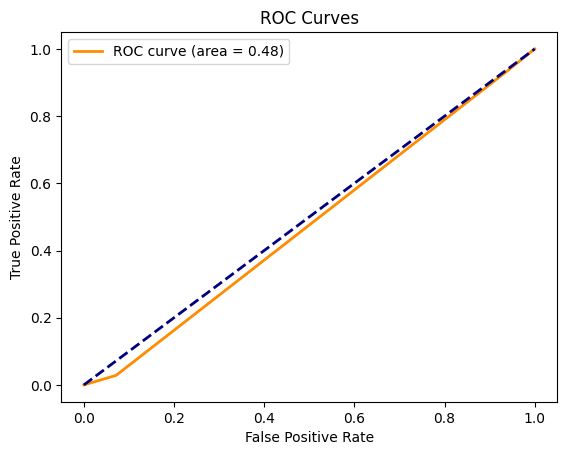

/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 1, pseudo-likelihood = -1279937120.22, time = 0.25s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 2, pseudo-likelihood = -2560034763.89, time = 0.34s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 3, pseudo-likelihood = -3840120132.52, time = 0.32s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 4, pseudo-likelihood = -5120193164.49, time = 0.33s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 5, pseudo-likelihood = -6400266202.11, time = 0.32s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 6, pseudo-likelihood = -7680339228.98, time = 0.32s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 7, pseudo-likelihood = -8960412262.67, time = 0.33s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 8, pseudo-likelihood = -10240485294.89, time = 0.32s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 9, pseudo-likelihood = -11520558325.87, time = 0.33s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -12800631359.32, time = 0.33s
Epoch 1/10


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


227/227 [==============================] - 1s 1ms/step - loss: 0.1263 - accuracy: 0.8622 - val_loss: 0.1177 - val_accuracy: 0.8839
Epoch 2/10
227/227 [==============================] - 0s 1ms/step - loss: 0.1118 - accuracy: 0.8894 - val_loss: 0.1160 - val_accuracy: 0.8839
Epoch 3/10
227/227 [==============================] - 0s 963us/step - loss: 0.1100 - accuracy: 0.8894 - val_loss: 0.1139 - val_accuracy: 0.8839
Epoch 4/10
227/227 [==============================] - 0s 969us/step - loss: 0.1081 - accuracy: 0.8894 - val_loss: 0.1119 - val_accuracy: 0.8839
Epoch 5/10
227/227 [==============================] - 0s 962us/step - loss: 0.1063 - accuracy: 0.8894 - val_loss: 0.1103 - val_accuracy: 0.8839
Epoch 6/10
227/227 [==============================] - 0s 961us/step - loss: 0.1048 - accuracy: 0.8894 - val_loss: 0.1086 - val_accuracy: 0.8839
Epoch 7/10
227/227 [==============================] - 0s 1ms/step - loss: 0.1035 - accuracy: 0.8894 - val_loss: 0.1074 - val_accuracy: 0.8839
Epoch 8/1

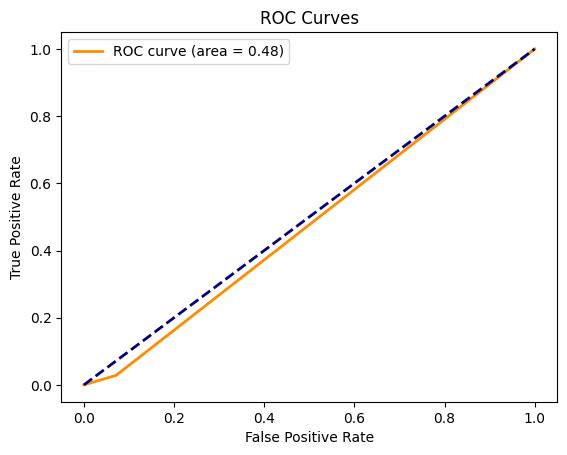

/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 1, pseudo-likelihood = -1187996538.64, time = 0.30s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 2, pseudo-likelihood = -2379472926.65, time = 0.46s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 3, pseudo-likelihood = -3570949274.85, time = 0.39s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 4, pseudo-likelihood = -4762425608.63, time = 0.41s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 5, pseudo-likelihood = -5953901957.81, time = 0.41s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 6, pseudo-likelihood = -7145377241.43, time = 0.40s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 7, pseudo-likelihood = -8336852535.35, time = 0.41s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 8, pseudo-likelihood = -9528326612.35, time = 0.40s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 9, pseudo-likelihood = -10719800687.43, time = 0.40s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -11911274767.83, time = 0.40s
Epoch 1/10


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


91/91 [==============================] - 1s 2ms/step - loss: 0.1219 - accuracy: 0.8821 - val_loss: 0.1110 - val_accuracy: 0.8909
Epoch 2/10
91/91 [==============================] - 0s 1ms/step - loss: 0.1171 - accuracy: 0.8821 - val_loss: 0.1094 - val_accuracy: 0.8909
Epoch 3/10
91/91 [==============================] - 0s 1ms/step - loss: 0.1158 - accuracy: 0.8821 - val_loss: 0.1080 - val_accuracy: 0.8909
Epoch 4/10
91/91 [==============================] - 0s 1ms/step - loss: 0.1146 - accuracy: 0.8821 - val_loss: 0.1068 - val_accuracy: 0.8909
Epoch 5/10
91/91 [==============================] - 0s 1ms/step - loss: 0.1133 - accuracy: 0.8821 - val_loss: 0.1057 - val_accuracy: 0.8909
Epoch 6/10
91/91 [==============================] - 0s 1ms/step - loss: 0.1124 - accuracy: 0.8821 - val_loss: 0.1051 - val_accuracy: 0.8909
Epoch 7/10
91/91 [==============================] - 0s 1ms/step - loss: 0.1116 - accuracy: 0.8821 - val_loss: 0.1043 - val_accuracy: 0.8909
Epoch 8/10
91/91 [=============

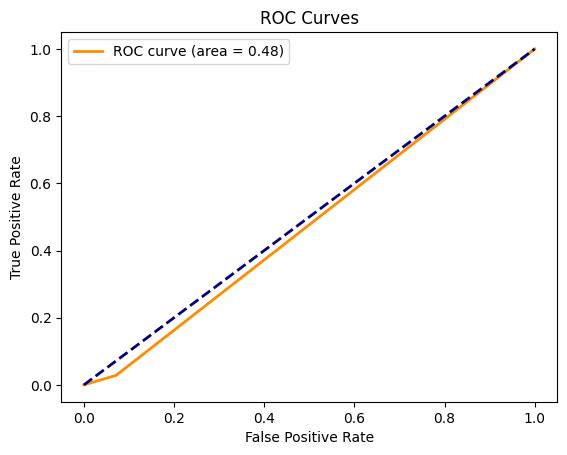

/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 1, pseudo-likelihood = -1619536574.34, time = 0.31s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 2, pseudo-likelihood = -3239275791.94, time = 0.44s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 3, pseudo-likelihood = -4859017117.22, time = 0.41s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 4, pseudo-likelihood = -6478758445.49, time = 0.42s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 5, pseudo-likelihood = -8098499770.03, time = 0.41s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 6, pseudo-likelihood = -9718238788.70, time = 0.41s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 7, pseudo-likelihood = -11337977804.98, time = 0.42s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 8, pseudo-likelihood = -12957716820.41, time = 0.42s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 9, pseudo-likelihood = -14577455837.93, time = 0.41s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -16197194853.28, time = 0.41s
Epoch 1/10


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


46/46 [==============================] - 1s 3ms/step - loss: 0.1304 - accuracy: 0.8638 - val_loss: 0.1317 - val_accuracy: 0.8646
Epoch 2/10
46/46 [==============================] - 0s 1ms/step - loss: 0.1167 - accuracy: 0.8838 - val_loss: 0.1308 - val_accuracy: 0.8646
Epoch 3/10
46/46 [==============================] - 0s 1ms/step - loss: 0.1161 - accuracy: 0.8838 - val_loss: 0.1301 - val_accuracy: 0.8646
Epoch 4/10
46/46 [==============================] - 0s 1ms/step - loss: 0.1156 - accuracy: 0.8838 - val_loss: 0.1301 - val_accuracy: 0.8646
Epoch 5/10
46/46 [==============================] - 0s 1ms/step - loss: 0.1149 - accuracy: 0.8838 - val_loss: 0.1290 - val_accuracy: 0.8646
Epoch 6/10
46/46 [==============================] - 0s 1ms/step - loss: 0.1143 - accuracy: 0.8838 - val_loss: 0.1283 - val_accuracy: 0.8646
Epoch 7/10
46/46 [==============================] - 0s 1ms/step - loss: 0.1138 - accuracy: 0.8838 - val_loss: 0.1275 - val_accuracy: 0.8646
Epoch 8/10
46/46 [=============

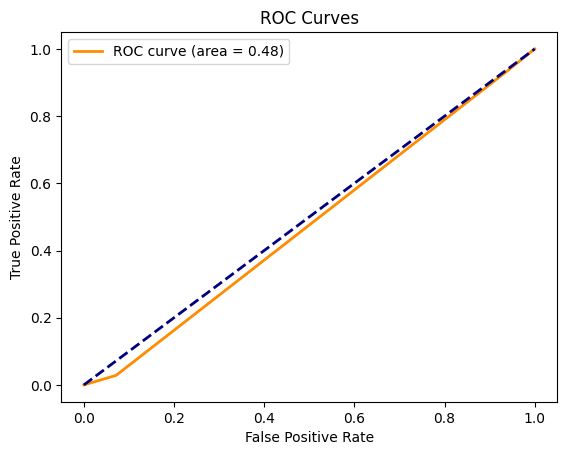

/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 1, pseudo-likelihood = -1556116749.16, time = 0.34s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 2, pseudo-likelihood = -3112444352.06, time = 0.46s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 3, pseudo-likelihood = -4668771962.90, time = 0.43s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 4, pseudo-likelihood = -6225099568.92, time = 0.43s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 5, pseudo-likelihood = -7781427179.30, time = 0.43s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 6, pseudo-likelihood = -9337754787.18, time = 0.43s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 7, pseudo-likelihood = -10894082390.00, time = 0.43s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 8, pseudo-likelihood = -12450409996.52, time = 0.44s


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 9, pseudo-likelihood = -14006737606.05, time = 0.42s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -15563065211.66, time = 0.43s
Epoch 1/10


/Users/wilfriedsankara/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


9/9 [==============================] - 0s 15ms/step - loss: 0.1851 - accuracy: 0.8924 - val_loss: 0.1708 - val_accuracy: 0.8767
Epoch 2/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1467 - accuracy: 0.8924 - val_loss: 0.1469 - val_accuracy: 0.8767
Epoch 3/10
9/9 [==============================] - 0s 4ms/step - loss: 0.1244 - accuracy: 0.8924 - val_loss: 0.1365 - val_accuracy: 0.8767
Epoch 4/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1154 - accuracy: 0.8924 - val_loss: 0.1330 - val_accuracy: 0.8767
Epoch 5/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1114 - accuracy: 0.8924 - val_loss: 0.1323 - val_accuracy: 0.8767
Epoch 6/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1099 - accuracy: 0.8924 - val_loss: 0.1323 - val_accuracy: 0.8767
Epoch 7/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1097 - accuracy: 0.8924 - val_loss: 0.1324 - val_accuracy: 0.8767
Epoch 8/10
9/9 [============================

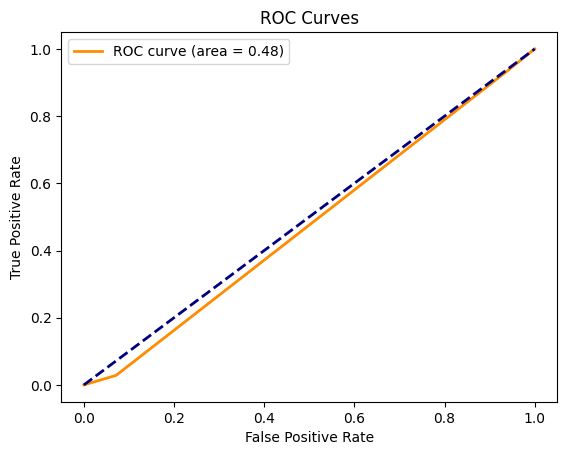

[0.8793541966161672, 0.8793541966161672, 0.8793541966161672, 0.8793541966161672, 0.8793541966161672]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.47759753986798886, 0.4784299864263491, 0.4784299864263491, 0.47759753986798886, 0.47759753986798886]


In [13]:
unlabelled_proportions = [0.5, 0.75, 0.9, 0.95, 0.99]
accuracies = []
f1_scores = []
runtimes = []
roc_auc_scores = []

for proportion in unlabelled_proportions :

    X_train,X_test,y_train_true,y_test_true = train_test_split(X,y,test_size=0.2, random_state=42)


    num_labelled_samples = int(len(X_train) * (1-proportion))
    X_label,y_label = X_train[:num_labelled_samples],y_train_true[:num_labelled_samples]
    X_unlabel = X_train[num_labelled_samples:]

    start_time = time.time()

    rbm = BernoulliRBM(n_components=100, learning_rate=0.1, batch_size=10, n_iter =10, verbose = True, random_state=42)

    rbm.fit(X_unlabel)

    X_label_rbm = rbm.transform(X_label)
    X_test_rbm = rbm.transform(X_test)

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

    model.compile(optimizer = "adam", loss = "mse",metrics = ["accuracy"])
    model.fit(X_label_rbm, y_label, epochs=10, batch_size=32, validation_split=0.2)

    # Evaluate the model
    y_pred = model.predict(X_test_rbm)
    
    end_time = time.time()  # Record end time
    runtime = end_time - start_time  # Calculate runtime
    runtimes.append(runtime)

    accuracies.append(accuracy_score(y_test_true, y_pred.round()))
    f1_scores.append(f1_score(y_test_true,y_pred.round()))

    # Calculate ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_test_true, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend() 
    plt.show()



print("Accuracies : ", accuracies)
print("F1-Score : ",f1_scores)
print("Runtimes : ",runtimes)

